In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance
from matplotlib import pyplot
model=xgb.XGBRegressor()
le=LabelEncoder()

In [2]:
path='C:/Files/HKUST/5001/self/'

In [3]:
train=pd.read_csv(path+'train.csv')
test=pd.read_csv(path+'test.csv')

##  Part 1 Data Set Exploring

In [4]:
train.head()

,id,penalty,l1_ratio,alpha,max_iter,random_state,n_jobs,n_samples,n_features,n_classes,n_clusters_per_class,n_informative,flip_y,scale,time
0,0,none,0.304083,0.0001,417,475,-1,1089,327,4,3,7,0.074798,24.242009,0.409987
1,1,l1,0.727744,0.0010,578,569,1,790,373,4,5,7,0.077781,54.626302,3.950953
2,2,none,0.745885,0.0100,588,529,2,428,1198,2,5,6,0.030196,17.999964,0.368702
3,3,none,0.474605,0.0010,829,103,4,877,313,6,5,7,0.057261,82.257222,1.004559
4,4,elasticnet,0.395049,0.0010,167,418,2,216,644,8,5,11,0.073728,95.515601,0.802800


**From a glimpse of training data set, it can be seen that ‘penalty’ is a category feature. Besides, ‘alpha’ only takes 3 different values, 0.0001, 0.001, 0.01, so it can be seen as a category feature as well. For the two columns, I’m going to transform them into integers with simple label encoder method.**


In [5]:
categories=['penalty','alpha']
for column in categories:
    train[column]=le.fit_transform(np.array(train[column]))
    test[column]=le.fit_transform(np.array(test[column]))

**The value -1 in column ‘n_jobs’ means that all CPUs are used for parallelized routines, which are different in different kinds of computers and may cause misleading. So I drop these rows which has -1 in ‘n_jobs’, and replace -1 with 16 in test data set.  * (16 came from prediction result. I've tried 2, 4, 8 and 16, it got highest score when -1 was replaced with 16 )*  **

**Besides, the building time was transformed to its log value, which can help deal with the situation that prediction value was smaller than 0. **

In [6]:
train=train.replace(-1,np.nan).dropna()
train_y=train['time'].ravel()
train_y=np.log(train_y)
train=train.drop(['time','id'],axis=1)
test=test.replace(-1,16)

**I choose *xgboost* to make prediction. First just simply see the importance of all the features in original training data set.**

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

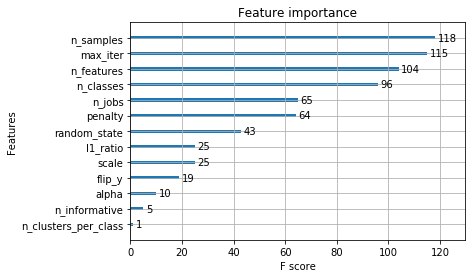

In [7]:
model.fit(train,train_y)
plot_importance(model)
pyplot.show()

## Part 2 Feature Engineering

**  According to the theory of *SGDClassifier*, if the input data set is a matrix of size $(n,p)$, training has a cost of  $O(n\overline{p}k)$ , where $k$ is the number of iterations (epochs) and $\overline{p}$ is the average number of non-zero attributes per sample. **
  
**  The synthetic dataset for training is generated using *sklearn.datasets.make_classification*. According to its explaination，‘n_samples’ means the number of samples, ‘n_features’ means the total number of features.**
  
**  Therefore, I considered to generate some more features from these important ones. **

In [8]:
train['kpn']=train['max_iter']*train['n_features']*train['n_samples']
test['kpn']=test['max_iter']*test['n_features']*test['n_samples']

train['iter_divide_jobs'] = train['max_iter'] / train['n_jobs']
test['iter_divide_jobs'] = test['max_iter'] / test['n_jobs']

train['samples_divide_jobs'] = train['n_samples'] / train['n_jobs']
test['samples_divide_jobs'] = test['n_samples'] / test['n_jobs']

train['features_divide_jobs']=train['n_features']/train['n_jobs']
test['features_divide_jobs']=test['n_features']/test['n_jobs']

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

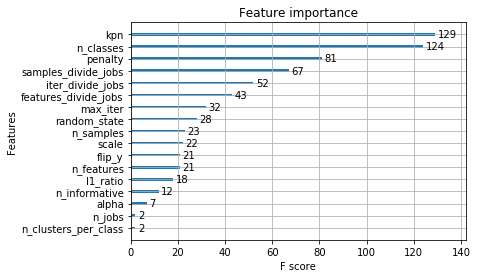

In [9]:
model.fit(train,train_y)
plot_importance(model)
pyplot.show()

**Some features may have influence on the practical training tasks, so I just kept them. The features I finally used is as bellow:**

In [10]:
featurelist=['penalty', 'l1_ratio', 'random_state','max_iter','n_jobs',
              'n_classes','n_clusters_per_class','flip_y', 'scale',
             'kpn', 'iter_divide_jobs','samples_divide_jobs', 'features_divide_jobs']

In [11]:
train_x=train[featurelist]
test_x=test[featurelist]

## Part 3 Build The Model

**Use *GridSearchCV* to get the best parameters.**

In [12]:
params=dict()
xgb_param_grid = {'max_depth': list(range(2,8)), 
                  'min_child_weight': list(range(1,8))}
grid = GridSearchCV(xgb.XGBRegressor(),
                param_grid=xgb_param_grid, cv=5,iid=True)

grid.fit(train_x, train_y)
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
params.update(grid.best_params_)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=None,
       param_grid={'min_child_weight': [1, 2, 3, 4, 5, 6, 7], 'max_depth': [2, 3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best: 0.957723 using {'min_child_weight': 1, 'max_depth': 2}


In [13]:
xgb_param_grid = {'gamma':[0.2,0.1,0.075,0.05,0.01,0.005,0.001,0]}

grid = GridSearchCV(xgb.XGBRegressor(**params),
                    param_grid=xgb_param_grid, cv=5,iid=True)

grid.fit(train_x, train_y)
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
params.update(grid.best_params_)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=None,
       param_grid={'gamma': [0.2, 0.1, 0.075, 0.05, 0.01, 0.005, 0.001, 0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best: 0.957723 using {'gamma': 0.01}


In [14]:
xgb_param_grid = {'subsample':[ 0.1 * i for i in range(5,9)],
                      'colsample_bytree':[ 0.1 * i for i in range(5,9)]}


grid = GridSearchCV(xgb.XGBRegressor(**params),
                    param_grid=xgb_param_grid, cv=5,iid=True)
grid.fit(train_x, train_y)
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
params.update(grid.best_params_)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.01, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=None,
       param_grid={'subsample': [0.5, 0.6000000000000001, 0.7000000000000001, 0.8], 'colsample_bytree': [0.5, 0.6000000000000001, 0.7000000000000001, 0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best: 0.963058 using {'subsample': 0.8, 'colsample_bytree': 0.6000000000000001}


In [15]:
xgb_param_grid = {'learning_rate':[0.4,0.3,0.2,0.1,0.05,0.01]}
grid = GridSearchCV(xgb.XGBRegressor(**params),
                    param_grid=xgb_param_grid, cv=5,iid=True)
grid.fit(train_x, train_y)
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
params.update(grid.best_params_)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6000000000000001, gamma=0.01, learning_rate=0.1,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8),
       fit_params=None, iid=True, n_jobs=None,
       param_grid={'learning_rate': [0.4, 0.3, 0.2, 0.1, 0.05, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best: 0.963058 using {'learning_rate': 0.1}


In [16]:
xgb_param_grid = {'n_estimators':[300,400,500,600,700,800]}

grid = GridSearchCV(xgb.XGBRegressor(**params),
                    param_grid=xgb_param_grid, cv=5,iid=True)

grid.fit(train_x, train_y)
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
params.update(grid.best_params_)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6000000000000001, gamma=0.01, learning_rate=0.1,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8),
       fit_params=None, iid=True, n_jobs=None,
       param_grid={'n_estimators': [300, 400, 500, 600, 700, 800]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best: 0.969462 using {'n_estimators': 600}


**After finding the best parmeters, build the final model.**

In [17]:
new_model=xgb.XGBRegressor(**params)

In [18]:
new_model.fit(train_x,train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6000000000000001, gamma=0.01, learning_rate=0.1,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=600, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)

**Don't forget that the prediction values are log values. Return them to the normal form and save into the file.**

In [19]:
result=new_model.predict(test_x)
result=np.exp(result)

In [20]:
result=pd.DataFrame({'time':result})
result['Id']=result.index
result=result[['Id','time']]
result.to_csv(path+'xgboost.csv',index=False)